# Great Energy Predictor III

In this competition, you’ll develop accurate models of metered building energy usage in the following areas: chilled water, electric, hot water, and steam meters. The data comes from over 1,000 buildings over a three-year timeframe. With better estimates of these energy-saving investments, large scale investors and financial institutions will be more inclined to invest in this area to enable progress in building efficiencies.

https://www.kaggle.com/c/ashrae-energy-prediction/overview/description

# Evaluation Metric

The evaluation metric for this competition is Root Mean Squared Logarithmic Error.

The RMSLE is calculated as

ϵ=1n∑i=1n(log(pi+1)−log(ai+1))2−−−−−−−−−−−−−−−−−−−−−−−−−−√
Where:

ϵ is the RMSLE value (score)
n is the total number of observations in the (public/private) data set,
pi is your prediction of target, and
ai is the actual target for i.
log(x) is the natural logarithm of x
Note that not all rows will necessarily be scored.

# library

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/data/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [47]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import matplotlib.patches as patches

from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
pd.set_option('max_columns', 150)

py.init_notebook_mode(connected=True)
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import matplotlib.patches as patches
from scipy import stats
from scipy.stats import skew

import os,random, math, psutil, pickle 

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from sklearn.model_selection import KFold, StratifiedKFold
from tqdm import tqdm

In [ ]:
print(os.listdir("../input/ashrae-energy-prediction/"))


In [4]:
%%time
root = '../input/ashrae-energy-prediction/'
train_df = pd.read_csv(root + 'train.csv')
train_df["timestamp"] = pd.to_datetime(train_df["timestamp"], format='%Y-%m-%d %H:%M:%S')

weather_train_df = pd.read_csv(root + 'weather_train.csv')
test_df = pd.read_csv(root + 'test.csv')
weather_test_df = pd.read_csv(root + 'weather_test.csv')
building_meta_df = pd.read_csv(root + 'building_metadata.csv')
sample_submission = pd.read_csv(root + 'sample_submission.csv')

CPU times: user 41.9 s, sys: 6.39 s, total: 48.3 s
Wall time: 48.4 s


In [5]:
print('Size of train_df data', train_df.shape)
print('Size of weather_train_df data', weather_train_df.shape)
print('Size of weather_test_df data', weather_test_df.shape)
print('Size of building_meta_df data', building_meta_df.shape)

Size of train_df data (20216100, 4)
Size of weather_train_df data (139773, 9)
Size of weather_test_df data (277243, 9)
Size of building_meta_df data (1449, 6)


### Reducing mmory size

In [6]:
## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [7]:
## REducing memory
train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)

weather_train_df = reduce_mem_usage(weather_train_df)
weather_test_df = reduce_mem_usage(weather_test_df)
building_meta_df = reduce_mem_usage(building_meta_df)

Mem. usage decreased to 289.19 Mb (53.1% reduction)
Mem. usage decreased to 596.49 Mb (53.1% reduction)
Mem. usage decreased to  3.07 Mb (68.1% reduction)
Mem. usage decreased to  6.08 Mb (68.1% reduction)
Mem. usage decreased to  0.03 Mb (60.3% reduction)


It is necessary that after using this code, carefully check the output results for each column.

### preparing Building DF and Weather DF 

In [8]:
train_df['timestamp'] = pd.to_datetime(train_df['timestamp'])
test_df['timestamp'] = pd.to_datetime(test_df['timestamp'])

weather_train_df['timestamp'] = pd.to_datetime(weather_train_df['timestamp'])
weather_test_df['timestamp'] = pd.to_datetime(weather_test_df['timestamp'])

building_meta_df['primary_use'] = building_meta_df['primary_use'].astype('category')

In [9]:
temp_df = train_df[['building_id']]
temp_df = temp_df.merge(building_meta_df, on=['building_id'], how='left')
del temp_df['building_id']
train_df = pd.concat([train_df, temp_df], axis=1)

temp_df = test_df[['building_id']]
temp_df = temp_df.merge(building_meta_df, on=['building_id'], how='left')

del temp_df['building_id']
test_df = pd.concat([test_df, temp_df], axis=1)
del temp_df, building_meta_df

In [10]:
temp_df = train_df[['site_id','timestamp']]
temp_df = temp_df.merge(weather_train_df, on=['site_id','timestamp'], how='left')

del temp_df['site_id'], temp_df['timestamp']
train_df = pd.concat([train_df, temp_df], axis=1)

temp_df = test_df[['site_id','timestamp']]
temp_df = temp_df.merge(weather_test_df, on=['site_id','timestamp'], how='left')

del temp_df['site_id'], temp_df['timestamp']
test_df = pd.concat([test_df, temp_df], axis=1)

del temp_df, weather_train_df, weather_test_df

In [11]:
train_df.to_pickle('train_df.pkl')
test_df.to_pickle('test_df.pkl')
   
del train_df, test_df
gc.collect()

0

In [17]:
train_df = pd.read_pickle('train_df.pkl')
test_df = pd.read_pickle('test_df.pkl')

### Encoding variables

In [18]:
# Convert wind direction into categorical feature. We can split 360 degrees into 16-wind compass rose. 
# See this: https://en.wikipedia.org/wiki/Points_of_the_compass#16-wind_compass_rose
def degToCompass(num):
    val=int((num/22.5))
    arr=[i for i in range(0,16)]
    return arr[(val % 16)]

In [19]:
le = LabelEncoder()

train_df['primary_use'] = le.fit_transform(train_df['primary_use']).astype(np.int8)

test_df['primary_use'] = le.fit_transform(test_df['primary_use']).astype(np.int8)

In [21]:
train_df.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,age
0,0,0,2016-01-01,0.0,0,0,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,10.0
1,1,0,2016-01-01,0.0,0,0,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,14.0
2,2,0,2016-01-01,0.0,0,0,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,27.0
3,3,0,2016-01-01,0.0,0,0,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,16.0
4,4,0,2016-01-01,0.0,0,0,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,43.0


In [20]:
train_df['age'] = train_df['year_built'].max() - train_df['year_built'] + 1
test_df['age'] = test_df['year_built'].max() - test_df['year_built'] + 1

# Feature Selection

In [23]:
def average_imputation(df, column_name):
    imputation = df.groupby(['timestamp'])[column_name].mean()
    
    df.loc[df[column_name].isnull(), column_name] = df[df[column_name].isnull()][[column_name]].apply(lambda x: imputation[df['timestamp'][x.index]].values)
    del imputation
    return df

In [24]:
train_df = average_imputation(train_df, 'wind_speed')
train_df = average_imputation(train_df, 'wind_direction')

beaufort = [(0, 0, 0.3), (1, 0.3, 1.6), (2, 1.6, 3.4), (3, 3.4, 5.5), (4, 5.5, 8), (5, 8, 10.8), (6, 10.8, 13.9), 
          (7, 13.9, 17.2), (8, 17.2, 20.8), (9, 20.8, 24.5), (10, 24.5, 28.5), (11, 28.5, 33), (12, 33, 200)]

for item in beaufort:
    train_df.loc[(train_df['wind_speed']>=item[1]) & (train_df['wind_speed']<item[2]), 'beaufort_scale'] = item[0]

train_df['wind_direction'] = train_df['wind_direction'].apply(degToCompass)
train_df['beaufort_scale'] = train_df['beaufort_scale'].astype(np.uint8)
train_df["wind_direction"] = train_df['wind_direction'].astype(np.uint8)
train_df["meter"] = train_df['meter'].astype(np.uint8)
train_df["site_id"] = train_df['site_id'].astype(np.uint8)
    
    
test_df = average_imputation(test_df, 'wind_speed')
test_df = average_imputation(test_df, 'wind_direction')

for item in beaufort:
    test_df.loc[(test_df['wind_speed']>=item[1]) & (test_df['wind_speed']<item[2]), 'beaufort_scale'] = item[0]

test_df['wind_direction'] = test_df['wind_direction'].apply(degToCompass)
test_df['wind_direction'] = test_df['wind_direction'].apply(degToCompass)
test_df['beaufort_scale'] = test_df['beaufort_scale'].astype(np.uint8)
test_df["wind_direction"] = test_df['wind_direction'].astype(np.uint8)
test_df["meter"] = test_df['meter'].astype(np.uint8)
test_df["site_id"] = test_df['site_id'].astype(np.uint8)

### Feature Engineering

In [26]:
###Datetime Features

In [27]:
train_df['month_datetime'] = train_df['timestamp'].dt.month.astype(np.int8)
train_df['weekofyear_datetime'] = train_df['timestamp'].dt.weekofyear.astype(np.int8)
train_df['dayofyear_datetime'] = train_df['timestamp'].dt.dayofyear.astype(np.int16)
    
train_df['hour_datetime'] = train_df['timestamp'].dt.hour.astype(np.int8)  
train_df['day_week'] = train_df['timestamp'].dt.dayofweek.astype(np.int8)
train_df['day_month_datetime'] = train_df['timestamp'].dt.day.astype(np.int8)
train_df['week_month_datetime'] = train_df['timestamp'].dt.day/7
train_df['week_month_datetime'] = train_df['week_month_datetime'].apply(lambda x: math.ceil(x)).astype(np.int8)
    
    
test_df['month_datetime'] = test_df['timestamp'].dt.month.astype(np.int8)
test_df['weekofyear_datetime'] = test_df['timestamp'].dt.weekofyear.astype(np.int8)
test_df['dayofyear_datetime'] = test_df['timestamp'].dt.dayofyear.astype(np.int16)
    
test_df['hour_datetime'] = test_df['timestamp'].dt.hour.astype(np.int8)
test_df['day_week'] = test_df['timestamp'].dt.dayofweek.astype(np.int8)
test_df['day_month_datetime'] = test_df['timestamp'].dt.day.astype(np.int8)
test_df['week_month_datetime'] = test_df['timestamp'].dt.day/7
test_df['week_month_datetime'] = test_df['week_month_datetime'].apply(lambda x: math.ceil(x)).astype(np.int8)

In [28]:
train_df.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,age,beaufort_scale,month_datetime,weekofyear_datetime,dayofyear_datetime,hour_datetime,day_week,day_month_datetime,week_month_datetime
0,0,0,2016-01-01,0.0,0,0,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.5,0,0.0,10.0,0,1,53,1,0,4,1,1
1,1,0,2016-01-01,0.0,0,0,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.5,0,0.0,14.0,0,1,53,1,0,4,1,1
2,2,0,2016-01-01,0.0,0,0,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.5,0,0.0,27.0,0,1,53,1,0,4,1,1
3,3,0,2016-01-01,0.0,0,0,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.5,0,0.0,16.0,0,1,53,1,0,4,1,1
4,4,0,2016-01-01,0.0,0,0,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.5,0,0.0,43.0,0,1,53,1,0,4,1,1


In [29]:
train_df.columns.values

array(['building_id', 'meter', 'timestamp', 'meter_reading', 'site_id',
       'primary_use', 'square_feet', 'year_built', 'floor_count',
       'air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed', 'age', 'beaufort_scale', 'month_datetime',
       'weekofyear_datetime', 'dayofyear_datetime', 'hour_datetime',
       'day_week', 'day_month_datetime', 'week_month_datetime'],
      dtype=object)

### Exploratory Data Analysis

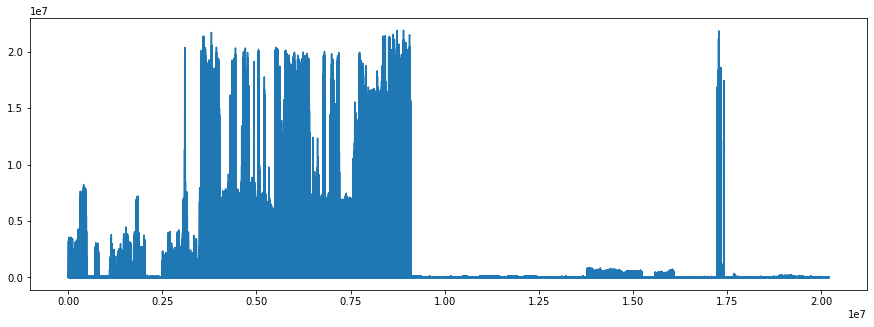

In [31]:
plt.figure(figsize = (15,5))
train_df['meter_reading'].plot()

The target is meter_reading - Energy consumption in kWh (or equivalent). Note that this is real data with measurement error, which we expect will impose a baseline level of modeling error.

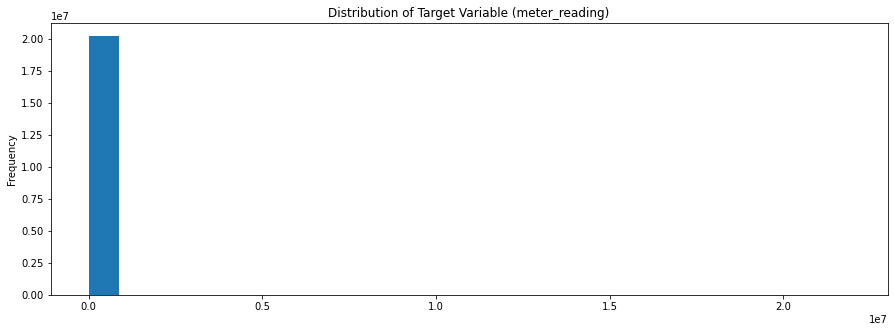

In [32]:
train_df['meter_reading'].plot(kind='hist',
                            bins=25,
                            figsize=(15, 5),
                           title='Distribution of Target Variable (meter_reading)')
plt.show()

count    2.021610e+07
mean     1.988706e+03
std      1.532159e+05
min      0.000000e+00
25%      1.830000e+01
50%      7.877500e+01
75%      2.679840e+02
max      2.190470e+07
Name: meter_reading, dtype: float64

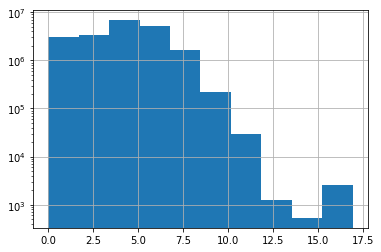

In [33]:
#Target's log-log histogram:
ax = np.log1p(train_df['meter_reading']).hist()
ax.set_yscale('log')
train_df.meter_reading.describe()

### Handling Missing Values

In [35]:
# checking missing data
total = train_df.isnull().sum().sort_values(ascending = False)
percent = (train_df.isnull().sum()/train_df.isnull().count()*100).sort_values(ascending = False)
missing__train_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing__train_data.head(10)

,Total,Percent
floor_count,16709167,82.652772
age,12127645,59.990033
year_built,12127645,59.990033
cloud_coverage,8825365,43.655131
precip_depth_1_hr,3749023,18.544739
sea_level_pressure,1231669,6.092515
dew_temperature,100140,0.495348
air_temperature,96658,0.478124
meter,0,0.000000
timestamp,0,0.000000


In [39]:
!pip install quilt
import missingno as msno

In [38]:
!pip install --upgrade pip

     |████████████████████████████████| 1.5 MB 402 kB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 20.1.1
    Uninstalling pip-20.1.1:
      Successfully uninstalled pip-20.1.1


Nullity Matrix

The msno.matrix nullity matrix is a data-dense display which lets you quickly visually analyse data completion.

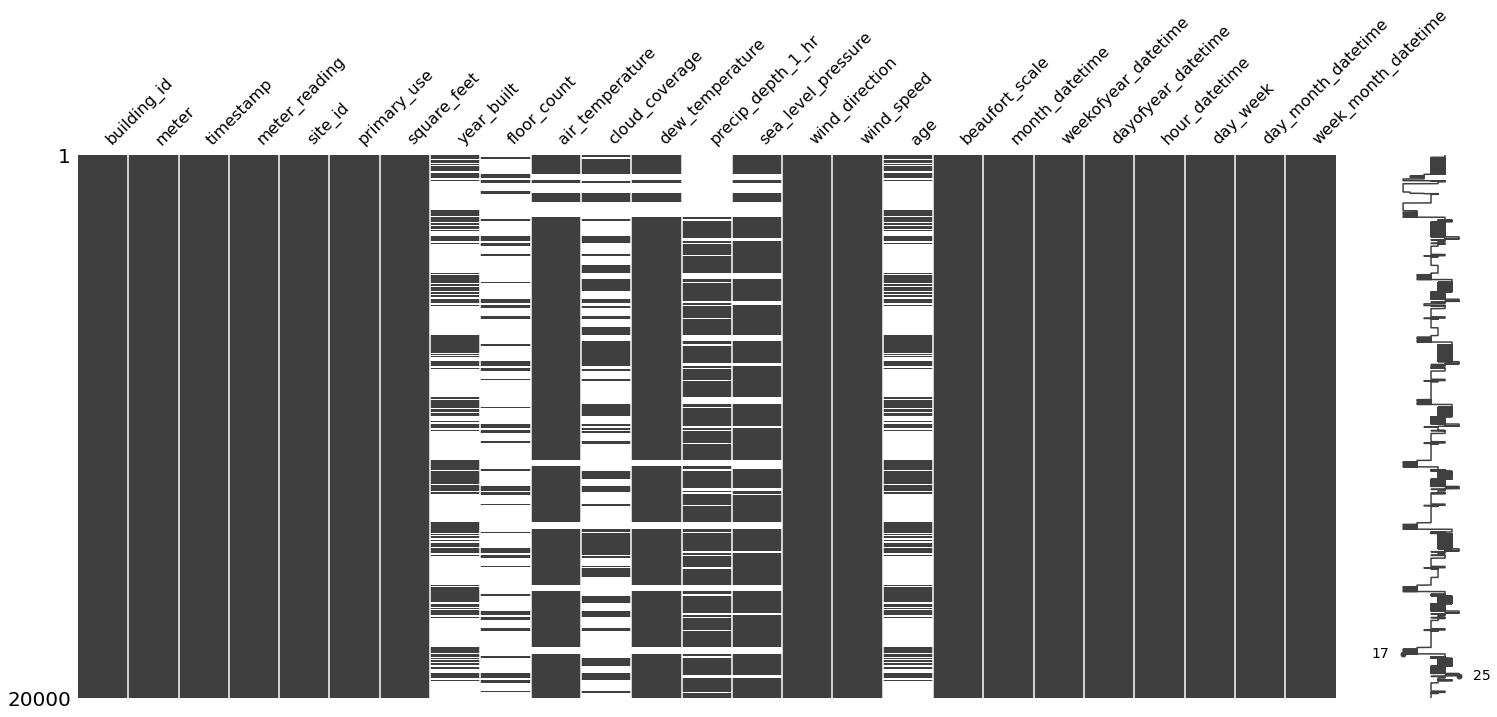

In [40]:
msno.matrix(train_df.head(20000))

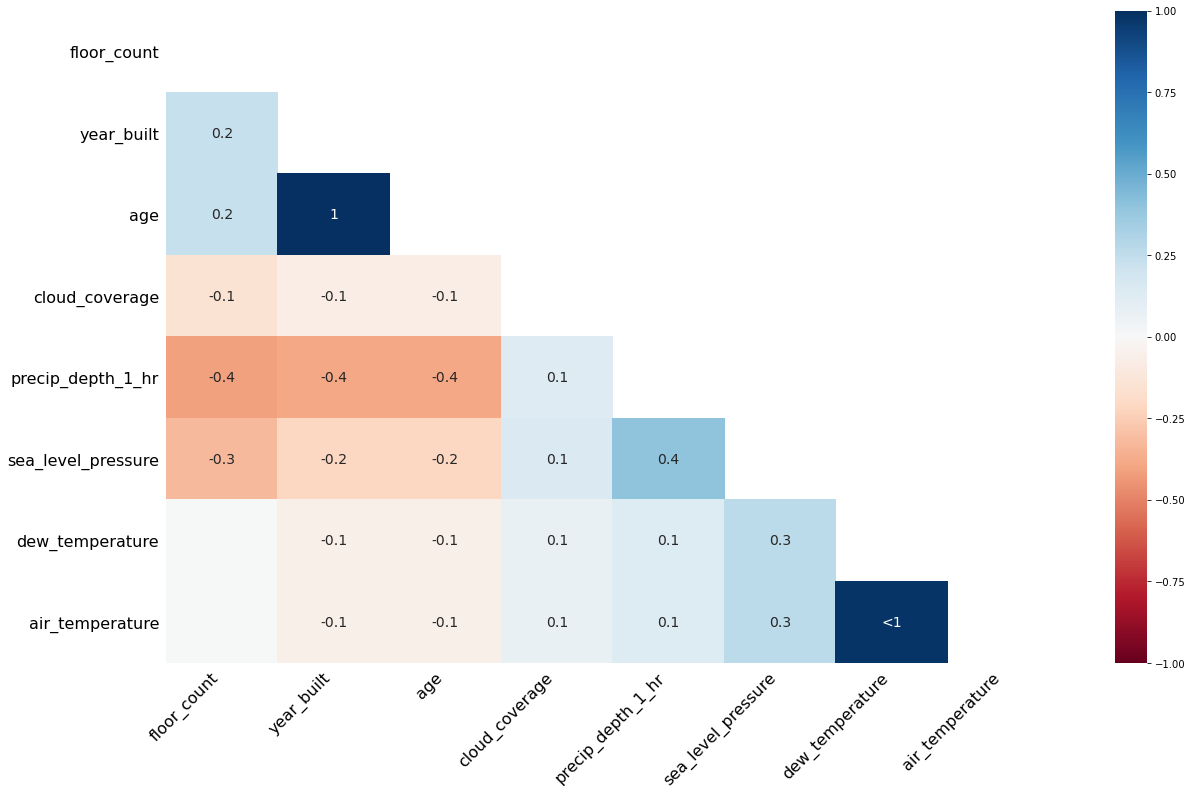

In [41]:
#Heat map
a = msno.heatmap(train_df, sort='ascending')

Manually dealing with missing values will often improve model performance.

Our approach we input fillNaN = -999 just for the 4 features with most missing values.

In [42]:
train_df['floor_count'] = train_df['floor_count'].fillna(-999).astype(np.int16)
test_df['floor_count'] = test_df['floor_count'].fillna(-999).astype(np.int16)

train_df['year_built'] = train_df['year_built'].fillna(-999).astype(np.int16)
test_df['year_built'] = test_df['year_built'].fillna(-999).astype(np.int16)

train_df['age'] = train_df['age'].fillna(-999).astype(np.int16)
test_df['age'] = test_df['age'].fillna(-999).astype(np.int16)

train_df['cloud_coverage'] = train_df['cloud_coverage'].fillna(-999).astype(np.int16)
test_df['cloud_coverage'] = test_df['cloud_coverage'].fillna(-999).astype(np.int16) 

In [43]:
#Outlier Analysis
#https://www.kaggle.com/chmaxx/ashrae-eda-and-visualization-wip

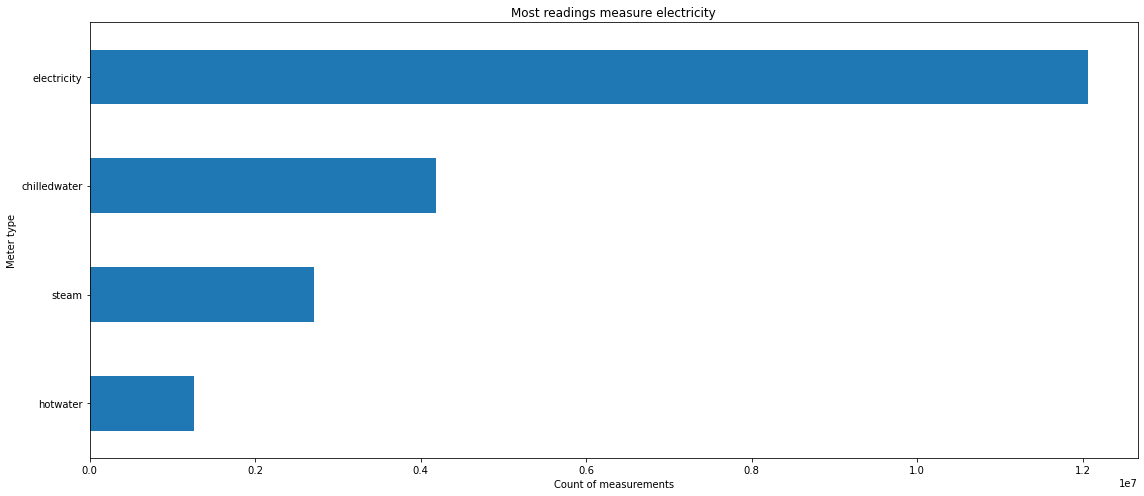

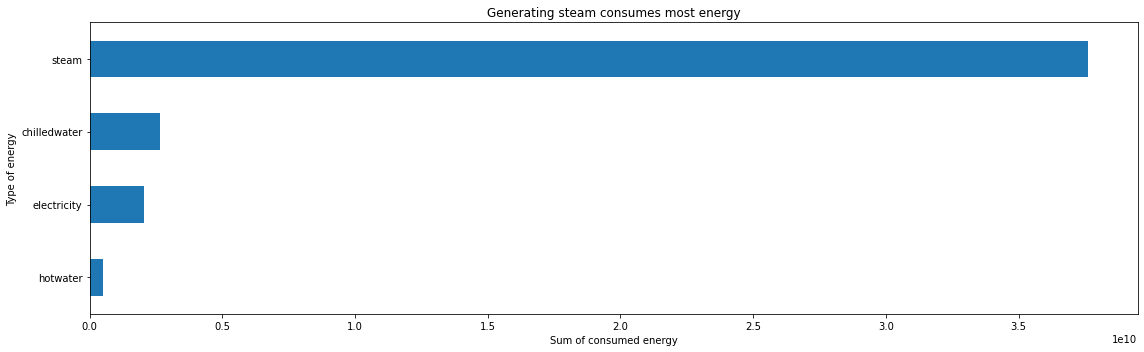

In [44]:
energy_types_dict = {0: "electricity", 1: "chilledwater", 2: "steam", 3: "hotwater"}
energy_types      = ['electricity', 'chilledwater', 'steam', 'hotwater']

plt.figure(figsize=(16,7))
tmp_df = train_df.meter.value_counts()
tmp_df.index = energy_types
tmp_df.sort_values().plot(kind="barh")
plt.title(f"Most readings measure electricity")
plt.xlabel("Count of measurements")
plt.ylabel(f"Meter type")
plt.tight_layout()
plt.show()

plt.figure(figsize=(16,5))
tmp_df = train_df.groupby("meter").meter_reading.sum()
tmp_df.index = energy_types
tmp_df.sort_values().plot(kind="barh")
plt.title(f"Generating steam consumes most energy")
plt.xlabel("Sum of consumed energy")
plt.ylabel(f"Type of energy")
plt.tight_layout()
plt.show()

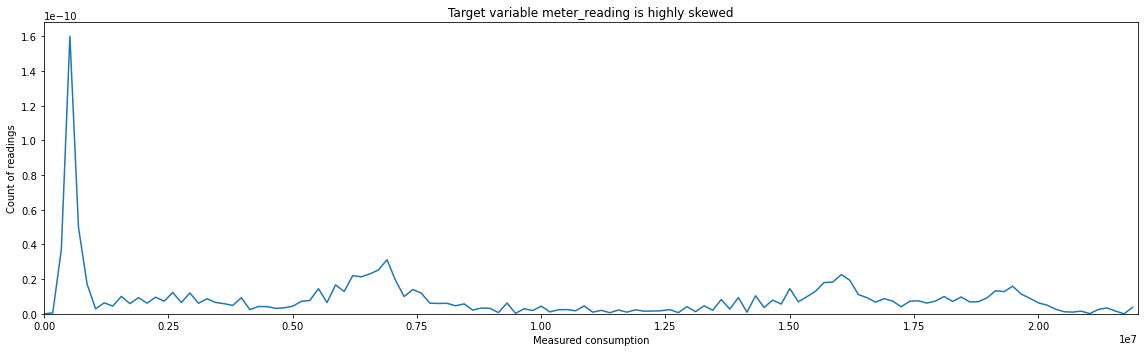

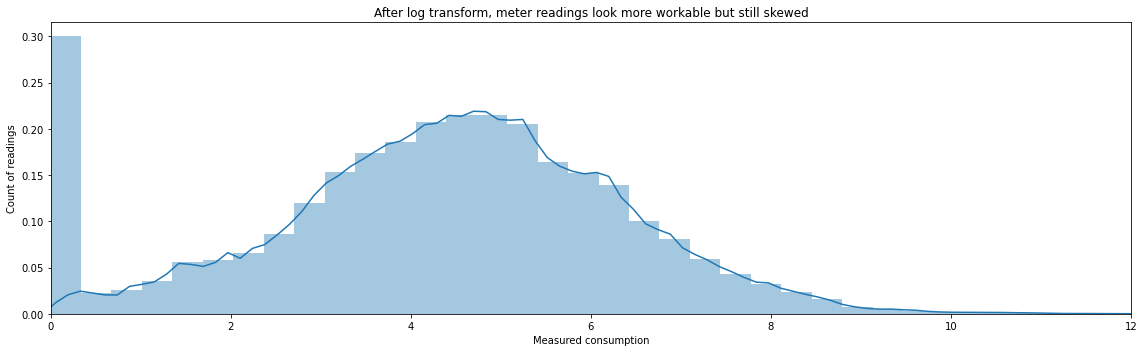

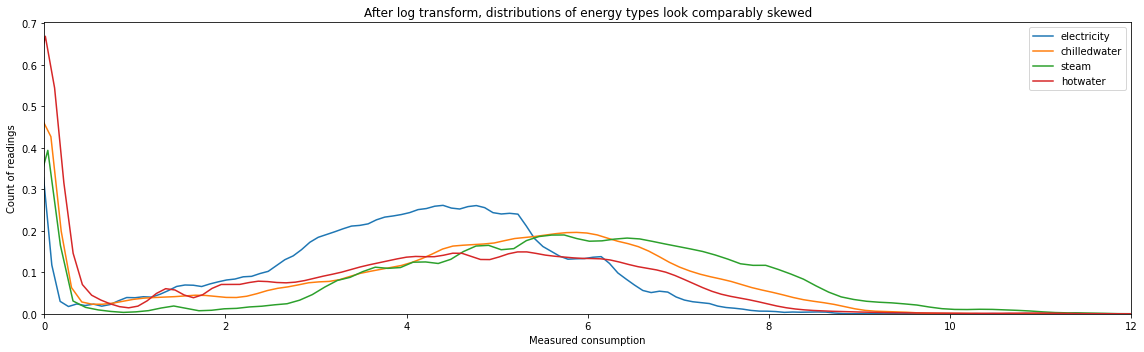

In [45]:
plt.figure(figsize=(16,5))
sns.distplot(train_df.meter_reading, hist=False)
plt.title(f"Target variable meter_reading is highly skewed")
plt.ylabel("Count of readings")
plt.xlabel(f"Measured consumption")
plt.xlim(0, train_df.meter_reading.max() + 100_000)
plt.tight_layout()
plt.show()

plt.figure(figsize=(16,5))
sns.distplot(np.log1p(train_df.meter_reading))
plt.title(f"After log transform, meter readings look more workable but still skewed")
plt.ylabel("Count of readings")
plt.xlabel(f"Measured consumption")
plt.xlim(0, 12)
plt.tight_layout()
plt.show()

plt.figure(figsize=(16,5))
for idx in range(0,4):
    sns.distplot(np.log1p(train_df[train_df.meter==idx].meter_reading), hist=False, label=energy_types[idx])
plt.title(f"After log transform, distributions of energy types look comparably skewed")
plt.ylabel("Count of readings")
plt.xlabel(f"Measured consumption")
plt.legend()
plt.xlim(0, 12)
plt.tight_layout()
plt.show()

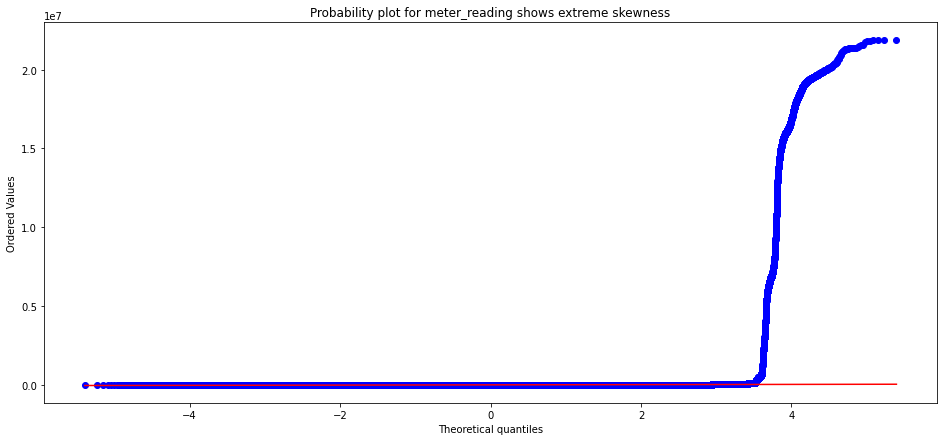

In [48]:
plt.figure(figsize=(16,7))
_ = stats.probplot(train_df['meter_reading'], plot=plt)
plt.title("Probability plot for meter_reading shows extreme skewness")
plt.show()

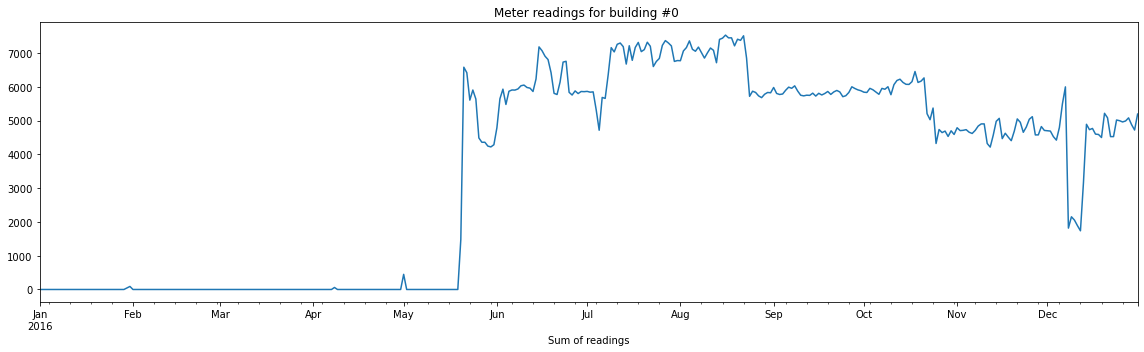

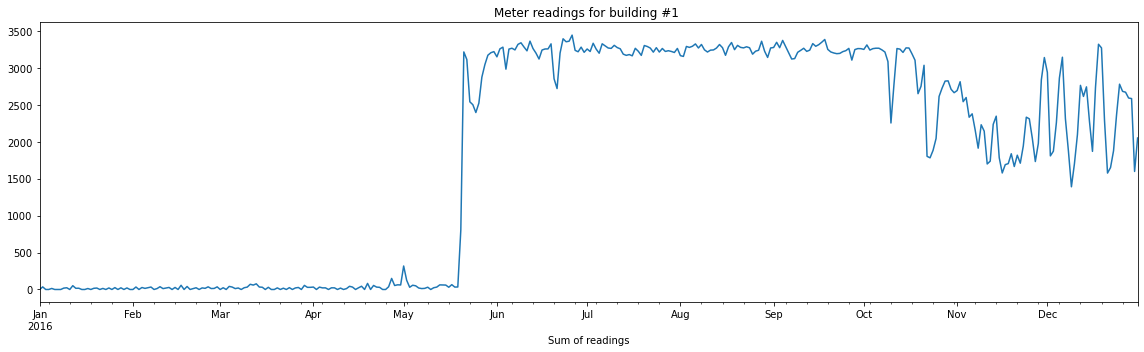

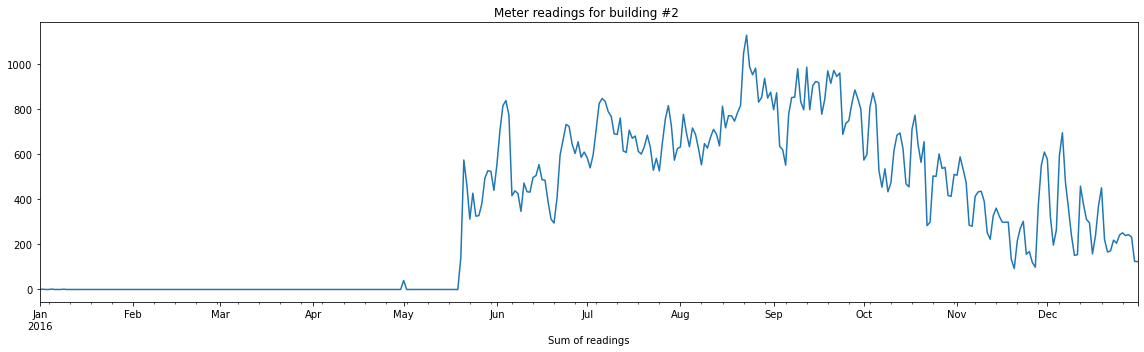

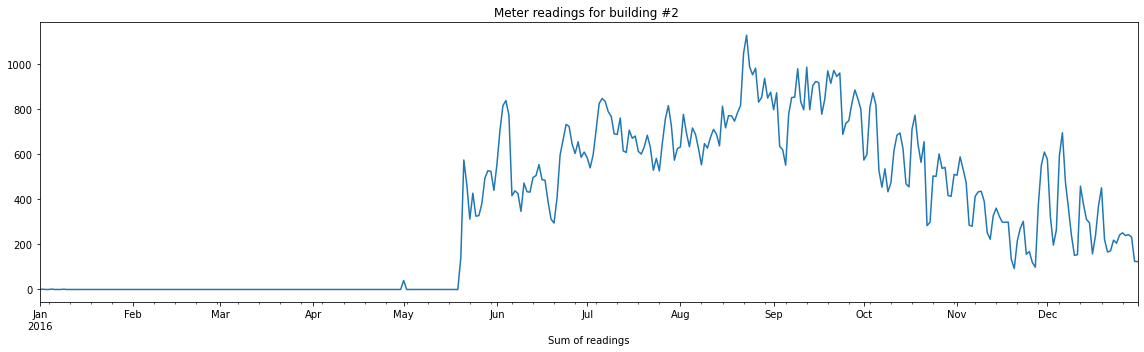

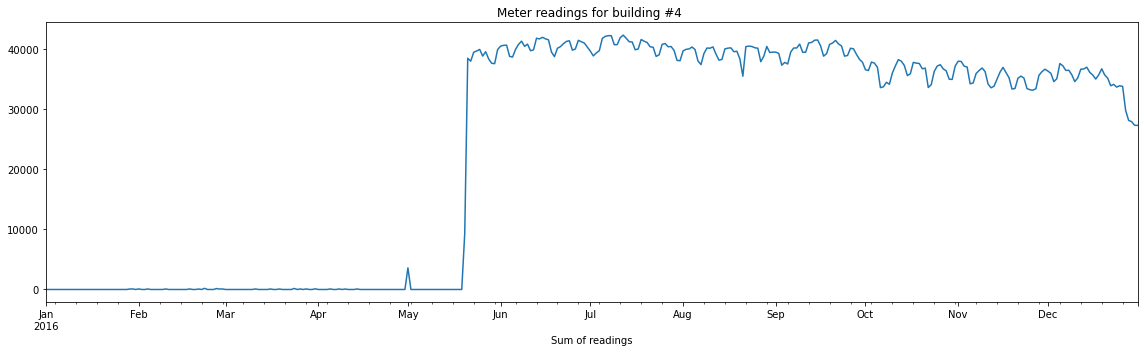

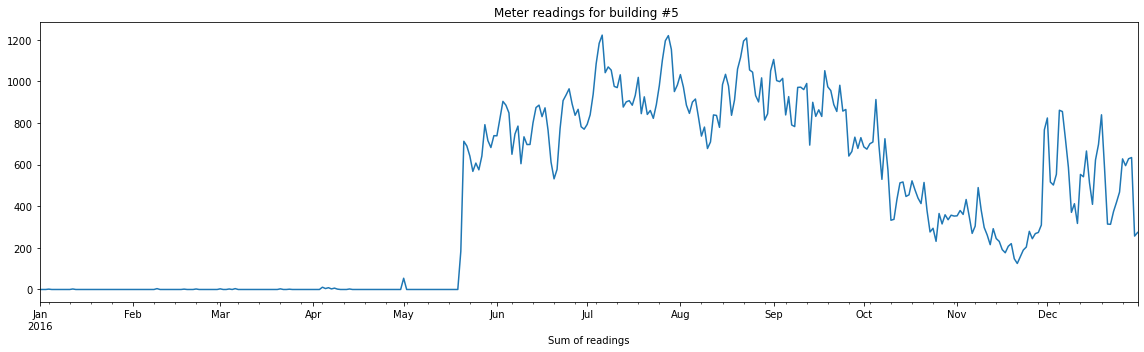

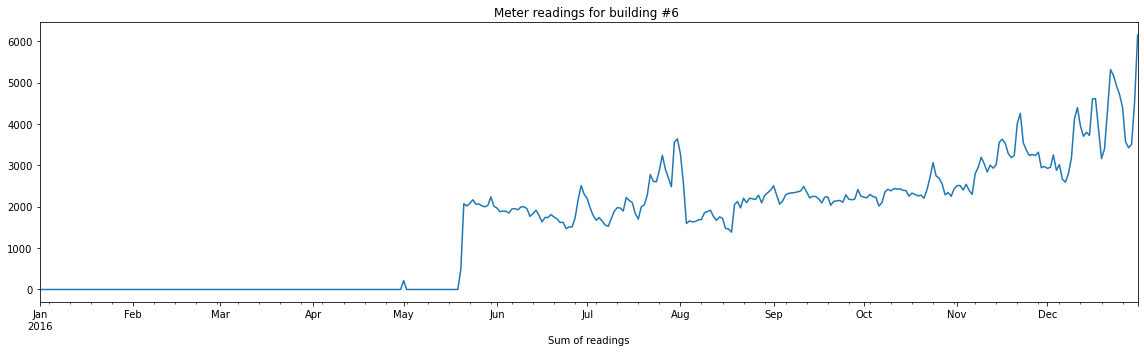

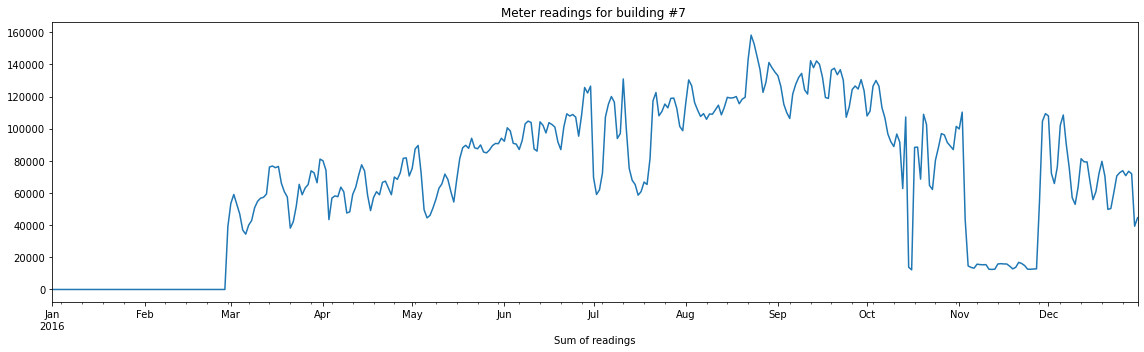

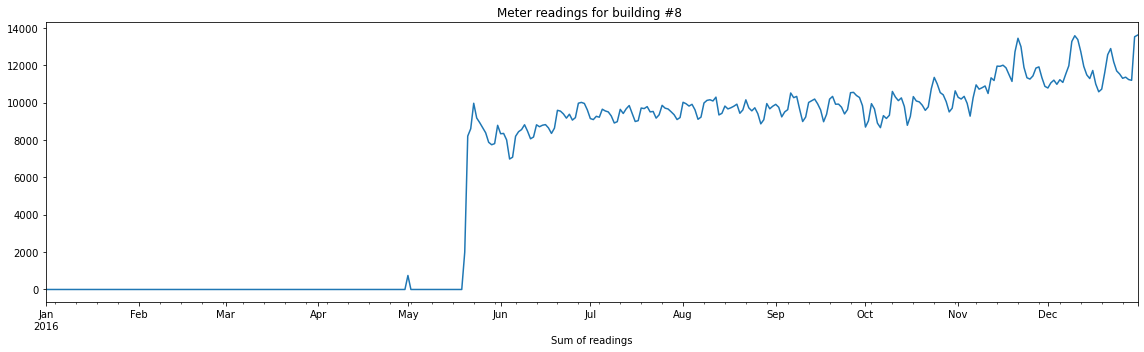

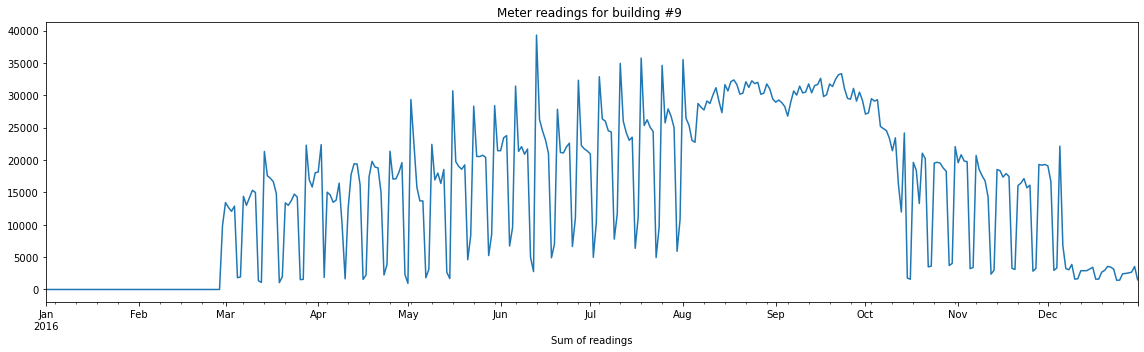

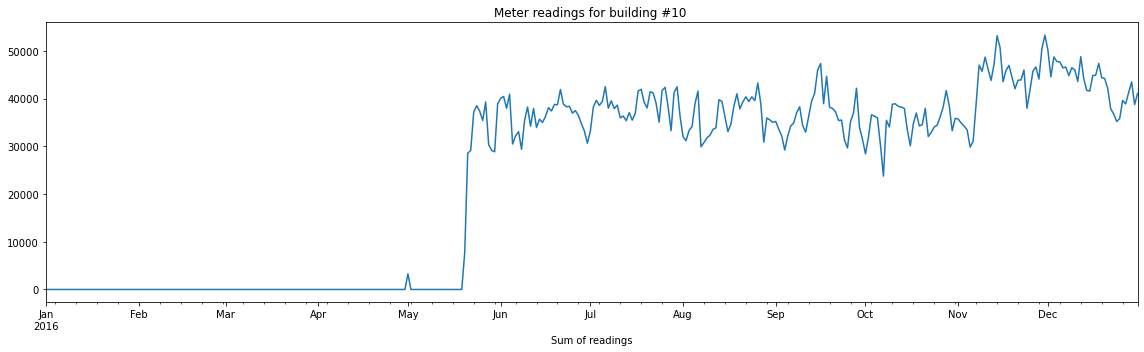

In [49]:
#Meter readings for first 10 buildings [ 1,2,3,4,5,6,7,8,9,10]
for bldg_id in [0, 1, 2, 2, 4,5, 6,7,8,9,10]:
    plt.figure(figsize=(16,5))
    tmp_df = train_df[train_df.building_id == bldg_id].copy()
    tmp_df.set_index("timestamp", inplace=True)
    tmp_df.resample("D").meter_reading.sum().plot()
    plt.title(f"Meter readings for building #{bldg_id} ")
    plt.xlabel("Sum of readings")
    plt.tight_layout()
    plt.show()

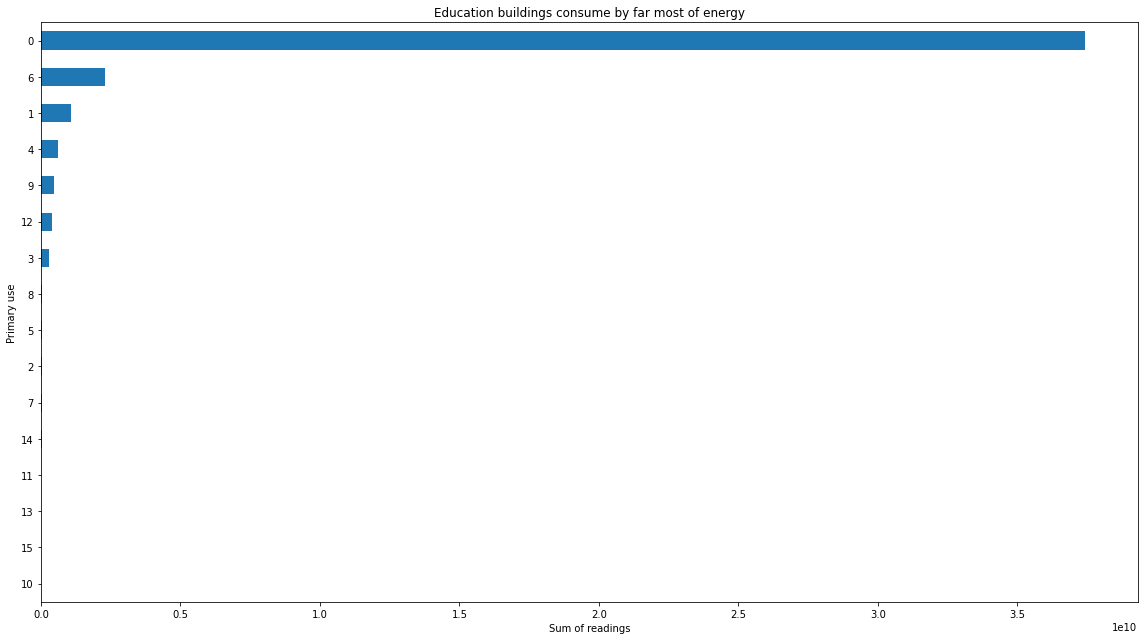

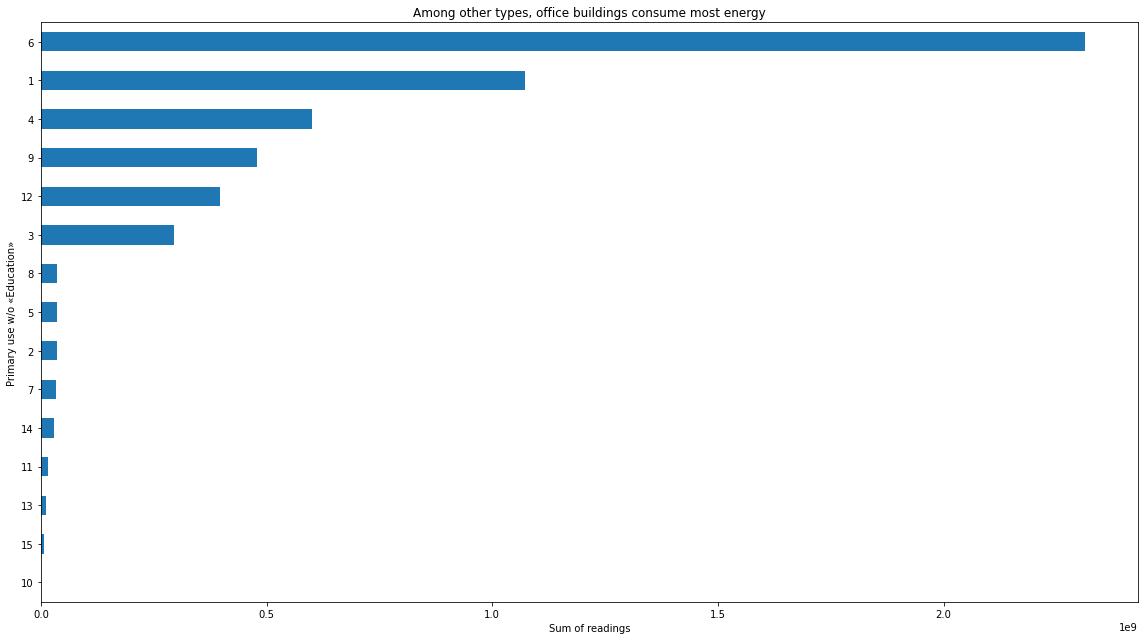

In [50]:
temp_df = train_df.groupby("primary_use").meter_reading.sum().sort_values()

plt.figure(figsize=(16,9))
temp_df.plot(kind="barh")
plt.title(f"Education buildings consume by far most of energy")
plt.xlabel("Sum of readings")
plt.ylabel(f"Primary use")
plt.tight_layout()
plt.show()

plt.figure(figsize=(16,9))
temp_df[:-1].plot(kind="barh")
plt.title(f"Among other types, office buildings consume most energy")
plt.xlabel("Sum of readings")
plt.ylabel(f"Primary use w/o «Education»")
plt.tight_layout()
plt.show()

#### Outlier Distribution

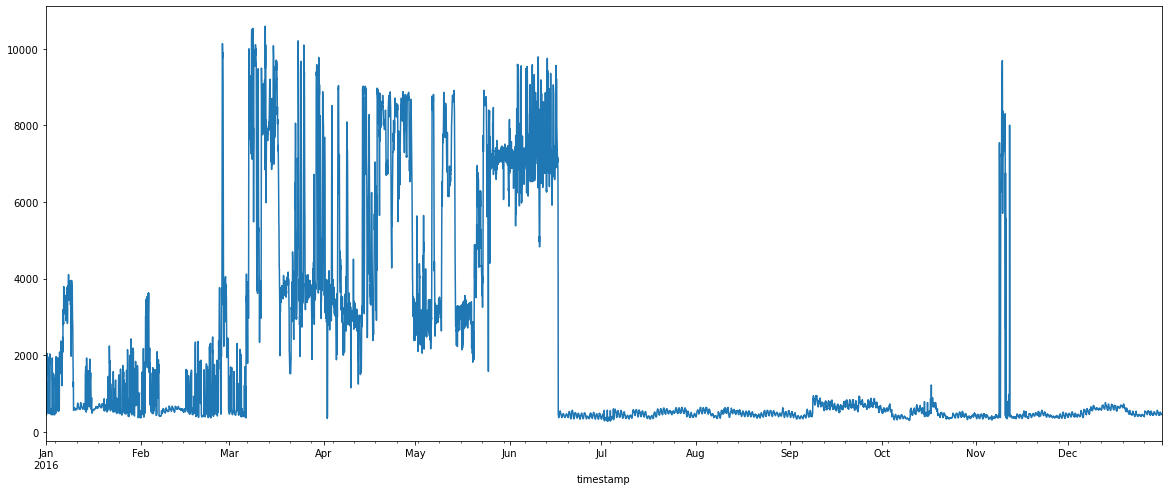

In [52]:
y_mean_time = train_df.groupby('timestamp').meter_reading.mean()
y_mean_time.plot(figsize=(20, 8))

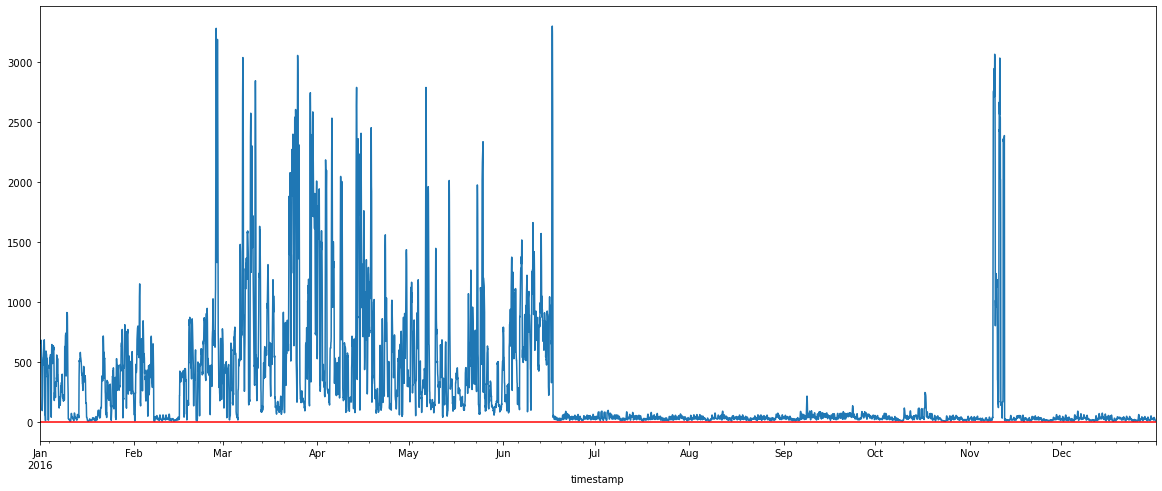

In [53]:
y_mean_time.rolling(window=10).std().plot(figsize=(20, 8))
plt.axhline(y=0.009, color='red')
plt.axvspan(0, 905, color='green', alpha=0.1)
plt.axvspan(906, 1505, color='red', alpha=0.1)

In [54]:
#https://www.kaggle.com/juanmah/ashrae-outliers
daily_train = train_df
daily_train['date'] = daily_train['timestamp'].dt.date
daily_train = daily_train.groupby(['date', 'building_id', 'meter']).sum()
daily_train

daily_train_agg = daily_train.groupby(['date', 'meter']).agg(['sum', 'mean', 'idxmax', 'max'])
daily_train_agg = daily_train_agg.reset_index()
level_0 = daily_train_agg.columns.droplevel(0)
level_1 = daily_train_agg.columns.droplevel(1)
level_0 = ['' if x == '' else '-' + x for x in level_0]
daily_train_agg.columns = level_1 + level_0
daily_train_agg.rename_axis(None, axis=1)
daily_train_agg.head()

,date,meter,meter_reading-sum,meter_reading-mean,meter_reading-idxmax,meter_reading-max,site_id-sum,site_id-mean,site_id-idxmax,site_id-max,primary_use-sum,primary_use-mean,primary_use-idxmax,primary_use-max,square_feet-sum,square_feet-mean,square_feet-idxmax,square_feet-max,year_built-sum,year_built-mean,year_built-idxmax,year_built-max,floor_count-sum,floor_count-mean,floor_count-idxmax,floor_count-max,air_temperature-sum,air_temperature-mean,air_temperature-idxmax,air_temperature-max,cloud_coverage-sum,cloud_coverage-mean,cloud_coverage-idxmax,cloud_coverage-max,dew_temperature-sum,dew_temperature-mean,dew_temperature-idxmax,dew_temperature-max,precip_depth_1_hr-sum,precip_depth_1_hr-mean,precip_depth_1_hr-idxmax,precip_depth_1_hr-max,sea_level_pressure-sum,sea_level_pressure-mean,sea_level_pressure-idxmax,sea_level_pressure-max,wind_direction-sum,wind_direction-mean,wind_direction-idxmax,wind_direction-max,wind_speed-sum,wind_speed-mean,wind_speed-idxmax,wind_speed-max,age-sum,age-mean,age-idxmax,age-max,beaufort_scale-sum,beaufort_scale-mean,beaufort_scale-idxmax,beaufort_scale-max,month_datetime-sum,month_datetime-mean,month_datetime-idxmax,month_datetime-max,weekofyear_datetime-sum,weekofyear_datetime-mean,weekofyear_datetime-idxmax,weekofyear_datetime-max,dayofyear_datetime-sum,dayofyear_datetime-mean,dayofyear_datetime-idxmax,dayofyear_datetime-max,hour_datetime-sum,hour_datetime-mean,hour_datetime-idxmax,hour_datetime-max,day_week-sum,day_week-mean,day_week-idxmax,day_week-max,day_month_datetime-sum,day_month_datetime-mean,day_month_datetime-idxmax,day_month_datetime-max,week_month_datetime-sum,week_month_datetime-mean,week_month_datetime-idxmax,week_month_datetime-max
0,2016-01-01,0,4.219648e+06,3037.903076,"(2016-01-01, 803, 0)",1.160372e+05,228225.0,164.308855,"(2016-01-01, 1326, 0)",360.0,114087.0,82.136069,"(2016-01-01, 164, 0)",360.0,3.084661e+09,2.220778e+06,"(2016-01-01, 869, 0)",21000000,12782697.0,9202.805616,"(2016-01-01, 363, 0)",48408.0,-25091007.0,-18064.079914,"(2016-01-01, 799, 0)",624.0,inf,153.375000,"(2016-01-01, 0, 0)",560.00,-19249228.0,-13858.335493,"(2016-01-01, 1033, 0)",159.0,18576.0,13.375,"(2016-01-01, 0, 0)",480.5,-1391.0,-1.000977,"(2016-01-01, 791, 0)",15.0,inf,20512.0,"(2016-01-01, 291, 0)",24496.0,258067.0,185.793377,"(2016-01-01, 291, 0)",321.0,inf,88.1875,"(2016-01-01, 1033, 0)",213.0000,-16983761.0,-12227.329734,"(2016-01-01, 124, 0)",2832.0,80290.0,57.804176,"(2016-01-01, 1033, 0)",112.0,33300.0,23.974082,"(2016-01-01, 0, 0)",24.0,1764900.0,1270.626350,"(2016-01-01, 0, 0)",1272.0,33300.0,23.974082,"(2016-01-01, 0, 0)",24.0,382999.0,275.737221,"(2016-01-01, 0, 0)",276.0,133200.0,95.896328,"(2016-01-01, 0, 0)",96.0,33300.0,23.974082,"(2016-01-01, 0, 0)",24.0,33300.0,23.974082,"(2016-01-01, 0, 0)",24.0
1,2016-01-01,0,4.219648e+06,3037.903076,"(2016-01-01, 803, 0)",1.160372e+05,228225.0,164.308855,"(2016-01-01, 1326, 0)",360.0,114087.0,82.136069,"(2016-01-01, 164, 0)",360.0,3.084661e+09,2.220778e+06,"(2016-01-01, 869, 0)",21000000,12782697.0,9202.805616,"(2016-01-01, 363, 0)",48408.0,-25091007.0,-18064.079914,"(2016-01-01, 799, 0)",624.0,inf,153.375000,"(2016-01-01, 0, 0)",560.00,-19249228.0,-13858.335493,"(2016-01-01, 1033, 0)",159.0,18576.0,13.375,"(2016-01-01, 0, 0)",480.5,-1391.0,-1.000977,"(2016-01-01, 791, 0)",15.0,inf,20512.0,"(2016-01-01, 291, 0)",24496.0,258067.0,185.793377,"(2016-01-01, 291, 0)",321.0,inf,88.1875,"(2016-01-01, 1033, 0)",213.0000,-16983761.0,-12227.329734,"(2016-01-01, 124, 0)",2832.0,80290.0,57.804176,"(2016-01-01, 1033, 0)",112.0,33300.0,23.974082,"(2016-01-01, 0, 0)",24.0,1764900.0,1270.626350,"(2016-01-01, 0, 0)",1272.0,33300.0,23.974082,"(2016-01-01, 0, 0)",24.0,382999.0,275.737221,"(2016-01-01, 0, 0)",276.0,133200.0,95.896328,"(2016-01-01, 0, 0)",96.0,33300.0,23.974082,"(2016-01-01, 0, 0)",24.0,33300.0,23.974082,"(2016-01-01, 0, 0)",24.0
2,2016-01-01,1,1.412169e+06,3090.084961,"(2016-01-01, 1289, 1)",1.042116e+05,107738.0,235.750547,"(2016-01-01, 1326, 1

In [55]:
#Aggregate the data for buildings
daily_train_agg = daily_train.groupby(['date', 'meter']).agg(['sum', 'mean', 'idxmax', 'max'])
daily_train_agg = daily_train_agg.reset_index()
level_0 = daily_train_agg.columns.droplevel(0)
level_1 = daily_train_agg.columns.droplevel(1)
level_0 = ['' if x == '' else '-' + x for x in level_0]
daily_train_agg.columns = level_1 + level_0
daily_train_agg.rename_axis(None, axis=1)
daily_train_agg.head()

,date,meter,meter_reading-sum,meter_reading-mean,meter_reading-idxmax,meter_reading-max,site_id-sum,site_id-mean,site_id-idxmax,site_id-max,primary_use-sum,primary_use-mean,primary_use-idxmax,primary_use-max,square_feet-sum,square_feet-mean,square_feet-idxmax,square_feet-max,year_built-sum,year_built-mean,year_built-idxmax,year_built-max,floor_count-sum,floor_count-mean,floor_count-idxmax,floor_count-max,air_temperature-sum,air_temperature-mean,air_temperature-idxmax,air_temperature-max,cloud_coverage-sum,cloud_coverage-mean,cloud_coverage-idxmax,cloud_coverage-max,dew_temperature-sum,dew_temperature-mean,dew_temperature-idxmax,dew_temperature-max,precip_depth_1_hr-sum,precip_depth_1_hr-mean,precip_depth_1_hr-idxmax,precip_depth_1_hr-max,sea_level_pressure-sum,sea_level_pressure-mean,sea_level_pressure-idxmax,sea_level_pressure-max,wind_direction-sum,wind_direction-mean,wind_direction-idxmax,wind_direction-max,wind_speed-sum,wind_speed-mean,wind_speed-idxmax,wind_speed-max,age-sum,age-mean,age-idxmax,age-max,beaufort_scale-sum,beaufort_scale-mean,beaufort_scale-idxmax,beaufort_scale-max,month_datetime-sum,month_datetime-mean,month_datetime-idxmax,month_datetime-max,weekofyear_datetime-sum,weekofyear_datetime-mean,weekofyear_datetime-idxmax,weekofyear_datetime-max,dayofyear_datetime-sum,dayofyear_datetime-mean,dayofyear_datetime-idxmax,dayofyear_datetime-max,hour_datetime-sum,hour_datetime-mean,hour_datetime-idxmax,hour_datetime-max,day_week-sum,day_week-mean,day_week-idxmax,day_week-max,day_month_datetime-sum,day_month_datetime-mean,day_month_datetime-idxmax,day_month_datetime-max,week_month_datetime-sum,week_month_datetime-mean,week_month_datetime-idxmax,week_month_datetime-max
0,2016-01-01,0,4.219648e+06,3037.903076,"(2016-01-01, 803, 0)",1.160372e+05,228225.0,164.308855,"(2016-01-01, 1326, 0)",360.0,114087.0,82.136069,"(2016-01-01, 164, 0)",360.0,3.084661e+09,2.220778e+06,"(2016-01-01, 869, 0)",21000000,12782697.0,9202.805616,"(2016-01-01, 363, 0)",48408.0,-25091007.0,-18064.079914,"(2016-01-01, 799, 0)",624.0,inf,153.375000,"(2016-01-01, 0, 0)",560.00,-19249228.0,-13858.335493,"(2016-01-01, 1033, 0)",159.0,18576.0,13.375,"(2016-01-01, 0, 0)",480.5,-1391.0,-1.000977,"(2016-01-01, 791, 0)",15.0,inf,20512.0,"(2016-01-01, 291, 0)",24496.0,258067.0,185.793377,"(2016-01-01, 291, 0)",321.0,inf,88.1875,"(2016-01-01, 1033, 0)",213.0000,-16983761.0,-12227.329734,"(2016-01-01, 124, 0)",2832.0,80290.0,57.804176,"(2016-01-01, 1033, 0)",112.0,33300.0,23.974082,"(2016-01-01, 0, 0)",24.0,1764900.0,1270.626350,"(2016-01-01, 0, 0)",1272.0,33300.0,23.974082,"(2016-01-01, 0, 0)",24.0,382999.0,275.737221,"(2016-01-01, 0, 0)",276.0,133200.0,95.896328,"(2016-01-01, 0, 0)",96.0,33300.0,23.974082,"(2016-01-01, 0, 0)",24.0,33300.0,23.974082,"(2016-01-01, 0, 0)",24.0
1,2016-01-01,0,4.219648e+06,3037.903076,"(2016-01-01, 803, 0)",1.160372e+05,228225.0,164.308855,"(2016-01-01, 1326, 0)",360.0,114087.0,82.136069,"(2016-01-01, 164, 0)",360.0,3.084661e+09,2.220778e+06,"(2016-01-01, 869, 0)",21000000,12782697.0,9202.805616,"(2016-01-01, 363, 0)",48408.0,-25091007.0,-18064.079914,"(2016-01-01, 799, 0)",624.0,inf,153.375000,"(2016-01-01, 0, 0)",560.00,-19249228.0,-13858.335493,"(2016-01-01, 1033, 0)",159.0,18576.0,13.375,"(2016-01-01, 0, 0)",480.5,-1391.0,-1.000977,"(2016-01-01, 791, 0)",15.0,inf,20512.0,"(2016-01-01, 291, 0)",24496.0,258067.0,185.793377,"(2016-01-01, 291, 0)",321.0,inf,88.1875,"(2016-01-01, 1033, 0)",213.0000,-16983761.0,-12227.329734,"(2016-01-01, 124, 0)",2832.0,80290.0,57.804176,"(2016-01-01, 1033, 0)",112.0,33300.0,23.974082,"(2016-01-01, 0, 0)",24.0,1764900.0,1270.626350,"(2016-01-01, 0, 0)",1272.0,33300.0,23.974082,"(2016-01-01, 0, 0)",24.0,382999.0,275.737221,"(2016-01-01, 0, 0)",276.0,133200.0,95.896328,"(2016-01-01, 0, 0)",96.0,33300.0,23.974082,"(2016-01-01, 0, 0)",24.0,33300.0,23.974082,"(2016-01-01, 0, 0)",24.0
2,2016-01-01,1,1.412169e+06,3090.084961,"(2016-01-01, 1289, 1)",1.042116e+05,107738.0,235.750547,"(2016-01-01, 1326, 1

In [56]:
fig_total = px.line(daily_train_agg, x='date', y='meter_reading-sum', color='meter', render_mode='svg')
fig_total.update_layout(title='Total kWh per energy aspect')
fig_total.show()

The sum for each energy aspect, shows some aberrant values.

meter=0 Eletricity

meter=1 Chilledwater

meter=2 Steam

meter=3 Hotwater

In [57]:
fig_maximum = px.line(daily_train_agg, x='date', y='meter_reading-max', color='meter', render_mode='svg')
fig_maximum.update_layout(title='Maximum kWh value per energy aspect')
fig_maximum.show()

In [58]:
daily_train_agg['building_id_max'] = [x[1] for x in daily_train_agg['meter_reading-idxmax']]
daily_train_agg.head()

,date,meter,meter_reading-sum,meter_reading-mean,meter_reading-idxmax,meter_reading-max,site_id-sum,site_id-mean,site_id-idxmax,site_id-max,primary_use-sum,primary_use-mean,primary_use-idxmax,primary_use-max,square_feet-sum,square_feet-mean,square_feet-idxmax,square_feet-max,year_built-sum,year_built-mean,year_built-idxmax,year_built-max,floor_count-sum,floor_count-mean,floor_count-idxmax,floor_count-max,air_temperature-sum,air_temperature-mean,air_temperature-idxmax,air_temperature-max,cloud_coverage-sum,cloud_coverage-mean,cloud_coverage-idxmax,cloud_coverage-max,dew_temperature-sum,dew_temperature-mean,dew_temperature-idxmax,dew_temperature-max,precip_depth_1_hr-sum,precip_depth_1_hr-mean,precip_depth_1_hr-idxmax,precip_depth_1_hr-max,sea_level_pressure-sum,sea_level_pressure-mean,sea_level_pressure-idxmax,sea_level_pressure-max,wind_direction-sum,wind_direction-mean,wind_direction-idxmax,wind_direction-max,wind_speed-sum,wind_speed-mean,wind_speed-idxmax,wind_speed-max,age-sum,age-mean,age-idxmax,age-max,beaufort_scale-sum,beaufort_scale-mean,beaufort_scale-idxmax,beaufort_scale-max,month_datetime-sum,month_datetime-mean,month_datetime-idxmax,month_datetime-max,weekofyear_datetime-sum,weekofyear_datetime-mean,weekofyear_datetime-idxmax,weekofyear_datetime-max,dayofyear_datetime-sum,dayofyear_datetime-mean,dayofyear_datetime-idxmax,dayofyear_datetime-max,hour_datetime-sum,hour_datetime-mean,hour_datetime-idxmax,hour_datetime-max,day_week-sum,day_week-mean,day_week-idxmax,day_week-max,day_month_datetime-sum,day_month_datetime-mean,day_month_datetime-idxmax,day_month_datetime-max,week_month_datetime-sum,week_month_datetime-mean,week_month_datetime-idxmax,week_month_datetime-max,building_id_max
0,2016-01-01,0,4.219648e+06,3037.903076,"(2016-01-01, 803, 0)",1.160372e+05,228225.0,164.308855,"(2016-01-01, 1326, 0)",360.0,114087.0,82.136069,"(2016-01-01, 164, 0)",360.0,3.084661e+09,2.220778e+06,"(2016-01-01, 869, 0)",21000000,12782697.0,9202.805616,"(2016-01-01, 363, 0)",48408.0,-25091007.0,-18064.079914,"(2016-01-01, 799, 0)",624.0,inf,153.375000,"(2016-01-01, 0, 0)",560.00,-19249228.0,-13858.335493,"(2016-01-01, 1033, 0)",159.0,18576.0,13.375,"(2016-01-01, 0, 0)",480.5,-1391.0,-1.000977,"(2016-01-01, 791, 0)",15.0,inf,20512.0,"(2016-01-01, 291, 0)",24496.0,258067.0,185.793377,"(2016-01-01, 291, 0)",321.0,inf,88.1875,"(2016-01-01, 1033, 0)",213.0000,-16983761.0,-12227.329734,"(2016-01-01, 124, 0)",2832.0,80290.0,57.804176,"(2016-01-01, 1033, 0)",112.0,33300.0,23.974082,"(2016-01-01, 0, 0)",24.0,1764900.0,1270.626350,"(2016-01-01, 0, 0)",1272.0,33300.0,23.974082,"(2016-01-01, 0, 0)",24.0,382999.0,275.737221,"(2016-01-01, 0, 0)",276.0,133200.0,95.896328,"(2016-01-01, 0, 0)",96.0,33300.0,23.974082,"(2016-01-01, 0, 0)",24.0,33300.0,23.974082,"(2016-01-01, 0, 0)",24.0,803
1,2016-01-01,0,4.219648e+06,3037.903076,"(2016-01-01, 803, 0)",1.160372e+05,228225.0,164.308855,"(2016-01-01, 1326, 0)",360.0,114087.0,82.136069,"(2016-01-01, 164, 0)",360.0,3.084661e+09,2.220778e+06,"(2016-01-01, 869, 0)",21000000,12782697.0,9202.805616,"(2016-01-01, 363, 0)",48408.0,-25091007.0,-18064.079914,"(2016-01-01, 799, 0)",624.0,inf,153.375000,"(2016-01-01, 0, 0)",560.00,-19249228.0,-13858.335493,"(2016-01-01, 1033, 0)",159.0,18576.0,13.375,"(2016-01-01, 0, 0)",480.5,-1391.0,-1.000977,"(2016-01-01, 791, 0)",15.0,inf,20512.0,"(2016-01-01, 291, 0)",24496.0,258067.0,185.793377,"(2016-01-01, 291, 0)",321.0,inf,88.1875,"(2016-01-01, 1033, 0)",213.0000,-16983761.0,-12227.329734,"(2016-01-01, 124, 0)",2832.0,80290.0,57.804176,"(2016-01-01, 1033, 0)",112.0,33300.0,23.974082,"(2016-01-01, 0, 0)",24.0,1764900.0,1270.626350,"(2016-01-01, 0, 0)",1272.0,33300.0,23.974082,"(2016-01-01, 0, 0)",24.0,382999.0,275.737221,"(2016-01-01, 0, 0)",276.0,133200.0,95.896328,"(2016-01-01, 0, 0)",96.0,33300.0,23.974082,"(2016-01-01, 0, 0)",24.0,33300.0,23.974082,"(2016-01-01, 0, 0)",24.0,803
2,2016-01-01,1,1.412169e+06,3090.084961,"(2016-01-01, 1289, 1)",1.042116e+05,107738.0,235.7505

# Modeling

### Data preparation

In [59]:
del train_df["timestamp"], test_df["timestamp"]
categoricals = ["site_id", "building_id", "primary_use",  "meter",  "wind_direction"] #"hour", "weekday",
drop_cols = ["sea_level_pressure", "wind_speed"]

numericals = ["square_feet", "year_built", "air_temperature", "cloud_coverage",
              "dew_temperature", 'precip_depth_1_hr', 'floor_count', 'beaufort_scale']

feat_cols = categoricals + numericals

In [60]:
target = np.log1p(train_df["meter_reading"])

del train_df["meter_reading"] 

train_df = train_df.drop(drop_cols, axis = 1)

#### Modeling simple LGBM

In [61]:
#simple k-fold cross validation

In [62]:
params = {
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': {'rmse'},
            'subsample_freq': 1,
            'learning_rate': 0.3,
            'bagging_freq': 5,
            'num_leaves': 330,
            'feature_fraction': 0.9,
            'lambda_l1': 1,  
            'lambda_l2': 1
            }

folds = 5
seed = 666
shuffle = False
kf = KFold(n_splits=folds, shuffle=shuffle, random_state=seed)

models = []
for train_index, val_index in kf.split(train_df[feat_cols], train_df['building_id']):
    train_X = train_df[feat_cols].iloc[train_index]
    val_X = train_df[feat_cols].iloc[val_index]
    train_y = target.iloc[train_index]
    val_y = target.iloc[val_index]
    lgb_train = lgb.Dataset(train_X, train_y, categorical_feature=categoricals)
    lgb_eval = lgb.Dataset(val_X, val_y, categorical_feature=categoricals)
    gbm = lgb.train(params,
                lgb_train,
                num_boost_round=500,
                valid_sets=(lgb_train, lgb_eval),
                early_stopping_rounds=50,
                verbose_eval = 50)
    models.append(gbm)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning:

Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.94896	valid_1's rmse: 1.2666
Early stopping, best iteration is:
[34]	training's rmse: 0.968494	valid_1's rmse: 1.26259
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.927933	valid_1's rmse: 1.28531
Early stopping, best iteration is:
[18]	training's rmse: 0.990694	valid_1's rmse: 1.2734
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.966793	valid_1's rmse: 1.09942
Early stopping, best iteration is:
[21]	training's rmse: 1.01445	valid_1's rmse: 1.09383
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.940128	valid_1's rmse: 1.21763
Early stopping, best iteration is:
[19]	training's rmse: 0.999754	valid_1's rmse: 1.20817
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.907018	valid_1's rmse: 1.46948
Early stopping, best iteration is:
[7]	training's rmse: 1.08182	

In [63]:
test_df = test_df[feat_cols]

In [2]:
import numpy as np
i=0
res=[]
step_size = 50000
for j in tqdm(range(int(np.ceil(test_df.shape[0]/50000)))):
    res.append(np.expm1(sum([model.predict(test_df.iloc[i:i+step_size]) for model in models])/folds))
    i+=step_size

In [65]:
res = np.concatenate(res)

In [66]:
#Submission

In [67]:
sample_submission['meter_reading'] = res
sample_submission.loc[sample_submission['meter_reading']<0, 'meter_reading'] = 0


In [4]:
import pandas as pd
sample_submission= pd.read_csv("submission.csv")

In [5]:
sample_submission.head()
#sample_submission.to_csv('submission.csv', index=False)

,row_id,meter_reading
0,0,17.550667
1,1,10.552085
2,2,2.316952
3,3,14.207939
4,4,25.399353
